In [189]:
%reset -f

In [190]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import seaborn as sns

In [191]:
X=pd.read_csv('train_call.tsv', sep='\t')
y=pd.read_csv('train_clinical.txt', sep='\t', index_col=0)

In [192]:
X = X.transpose()
X = X.tail(-4)

In [193]:
# Create a dictionary to map the string labels to integers
class_mapping = {'HER2+': 1, 'HR+': 2, 'Triple Neg': 3}
# Replace the string labels with integers using the mapping
y = y.replace(class_mapping)

In [194]:
# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [195]:
# Feature Selection using LassoCV (L1 regularization)
lasso = LassoCV(cv=5, random_state=42)
selector = SelectFromModel(lasso, max_features=100).fit(X, y.values.ravel())
X_selected = selector.transform(X)

In [196]:
# Dimensionality Reduction using PCA
pca = PCA(n_components=20, random_state=42)
X_pca = pca.fit_transform(X_selected)

In [197]:
# One-hot encode the target variable
y = to_categorical(y - 1, num_classes=3)

In [198]:
# Split the dataset into training and test sets
X_trainval, X_test, y_trainval, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Split the training set further into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.25, random_state=42)

In [199]:
# Build the neural network model with L2 regularization
model = Sequential()
model.add(Dense(32, input_shape=(20,), activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dense(3, activation='softmax', kernel_regularizer=l2(0.001)))

In [200]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [201]:
# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=10, verbose=0, validation_data=(X_val, y_val))

In [202]:
# Evaluate the model on the test set
y_pred = np.argmax(model.predict(X_test), axis=-1)
y_test = np.argmax(y_test, axis=1)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {accuracy:.3f}")

1/1 [==============================] - 0s 29ms/step
Test accuracy: 0.950


In [203]:
# Calculate accuracy, precision, recall, and F1-score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

In [204]:
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-score: {f1:.3f}")

Accuracy: 0.950
Precision: 0.957
Recall: 0.950
F1-score: 0.950


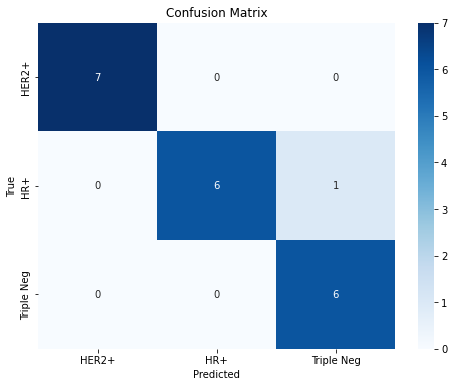

In [205]:
# Calculate and display the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_mapping.keys(), yticklabels=class_mapping.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

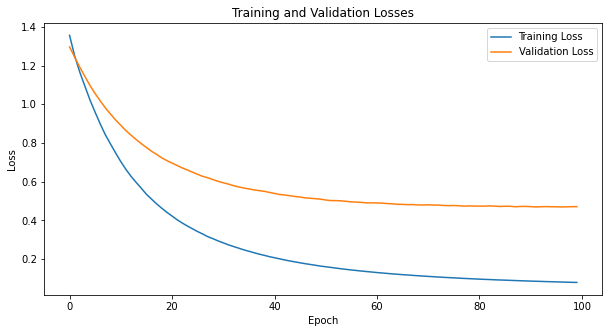

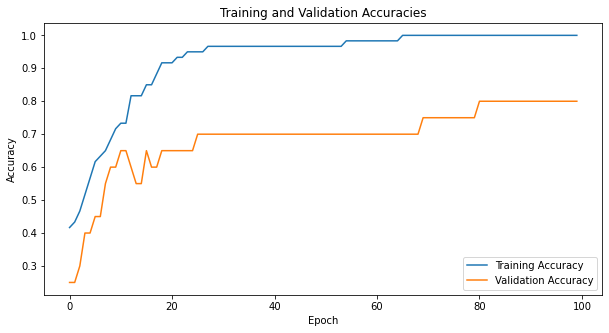

In [206]:
# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

# Plot the training and validation accuracies
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracies')
plt.legend()
plt.show()